# Torch playground

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

from extra.utils import *

## NN params

In [2]:
torch.cuda.is_available()

True

In [3]:
batch_size = 54 # gtx960
# batch_size = 256

## CIFAR preload

In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## MobileNetV2

In [5]:
from models.mobilenetv2 import *

## Prep

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [ ]:
net = MobileNetV2()
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001,
#                       momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

## Training

In [ ]:
losses = [] 
accuracies = []
def train_nn(epoch):
    net.train()
   
    with tqdm(trainloader, unit="batch") as tepoch:
        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            _, predictions = output.max(1)
            loss = criterion(output, target)
            correct = predictions.eq(target).sum().item()
            accuracy = (predictions == target).float().mean()

            loss.backward()
            optimizer.step()

            tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy.item())
            
            losses.append(loss)
            accuracies.append(accuracy)

In [ ]:
def test_nn(epoch):
    net.eval()
    with torch.no_grad():
        with tqdm(testloader, unit="batch") as tepoch:
            for data, target in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                
                data, target = data.to(device), target.to(device)
                output = net(data)
                _, predictions = output.max(1)
                loss = criterion(output, target)
                correct = predictions.eq(target).sum().item()
                accuracy = (predictions == target).float().mean()

                tepoch.set_postfix(loss=loss.item(), accuracy=100. * accuracy.item())

In [ ]:
for epoch in trange(0, 10): #start_epoch, start_epoch+200
    train_nn(epoch)
    test_nn(epoch)
    scheduler.step()

In [ ]:
plt.ylim(-0.1,2.2)
plt.plot(losses)
plt.plot(accuracies)

In [ ]:
torch.save(net.state_dict(), './state_dict_net.pt')

## Loading model

In [7]:
loaded_model = MobileNetV2()
loaded_model = loaded_model.to(device)
if device == 'cuda':
    loaded_model = torch.nn.DataParallel(loaded_model)
    cudnn.benchmark = True
loaded_model.load_state_dict(torch.load('./state_dict_net.pt'))

<All keys matched successfully>

In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images.to(device)
labels.to(device)

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


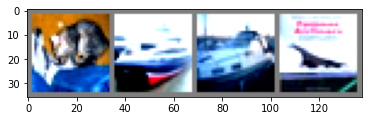

GroundTruth:    cat  ship  ship plane


In [9]:
imshow(torchvision.utils.make_grid(images[0:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Testing network, 4 images

In [10]:
loaded_outputs = loaded_model(images)
_, loaded_predicted = torch.max(loaded_outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[loaded_predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


## Testing network, 1000 images

In [11]:
correct = 0
total = 0
with torch.no_grad():
    with tqdm(testloader, unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            outputs = loaded_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

  0%|          | 0/186 [00:00<?, ?batch/s]

Accuracy of the network on the 10000 test images: 81 %


## Testing network, accuracy of the each class

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    with tqdm(testloader, unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            outputs = loaded_model(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

  0%|          | 0/186 [00:00<?, ?batch/s]

Accuracy of plane : 89 %
Accuracy of   car : 90 %
Accuracy of  bird : 66 %
Accuracy of   cat : 70 %
Accuracy of  deer : 76 %
Accuracy of   dog : 65 %
Accuracy of  frog : 88 %
Accuracy of horse : 85 %
Accuracy of  ship : 94 %
Accuracy of truck : 89 %
